# Exploring the Danceability of a song on Spotify based on multiple characteristics of the song

In [1]:
# Setting up prerequisites
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Load the data from the web into R
url <- "https://www.kaggle.com/c/titanic/data?select=test.csv/download"
spotify_big <- read_csv("data/SpotifyAudioFeaturesApril2019.csv")
head(spotify_big,5)

Rows: 130663 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): artist_name, track_id, track_name
dbl (14): acousticness, danceability, duration_ms, energy, instrumentalness,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",5.82e-03,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),2.44e-02,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,2.50e-02,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,2.94e-02,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,3.52e-05,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [3]:
# extract a sample of size 500 from the original data as our training data
set.seed(79)
raw_spotify <- spotify_big |> sample_n(500)

In [4]:
# clean and wrangle our training data into a tidy format
# due to the range of different predictors, we rescaled "energy", "valence" 
# and transform "mode" into the factor type as it only has two levels

spotify_training <- raw_spotify |>
                select(danceability, energy, valence, mode) |>
                mutate(energy = as.numeric(scale(energy)),
                       valence = as.numeric(scale(valence)),
                       mode = as_factor(mode))
head(spotify_training, 5)

danceability,energy,valence,mode
<dbl>,<dbl>,<dbl>,<fct>
0.760,0.34184436,-1.1323884,1
0.511,1.10553509,1.3947480,1
0.780,0.16389700,1.0298879,0
0.580,0.93129497,-0.6523093,0
0.692,0.00448583,1.8517833,1


In [5]:
# An aggregate statistical summary of the training data
spotify_training_summary <-  spotify_training |>
                             group_by(mode) |>
                             summarize(number_of_observation = n(),
                                       mean_danceability = mean(danceability),
                                       mean_energy = mean(energy),
                                       mean_valence = mean(valence),
                                       sd_danceability = sd(danceability),
                                       sd_energy = sd(energy),
                                       sd_valence = sd(valence))
spotify_training_summary

                                    
                                       

mode,number_of_observation,mean_danceability,mean_energy,mean_valence,sd_danceability,sd_energy,sd_valence
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,201,0.6175224,0.06205257,-0.02863809,0.1731343,0.9761161,0.950131
1,299,0.5668023,-0.04171427,0.01925170,0.1938895,1.0152284,1.033296


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



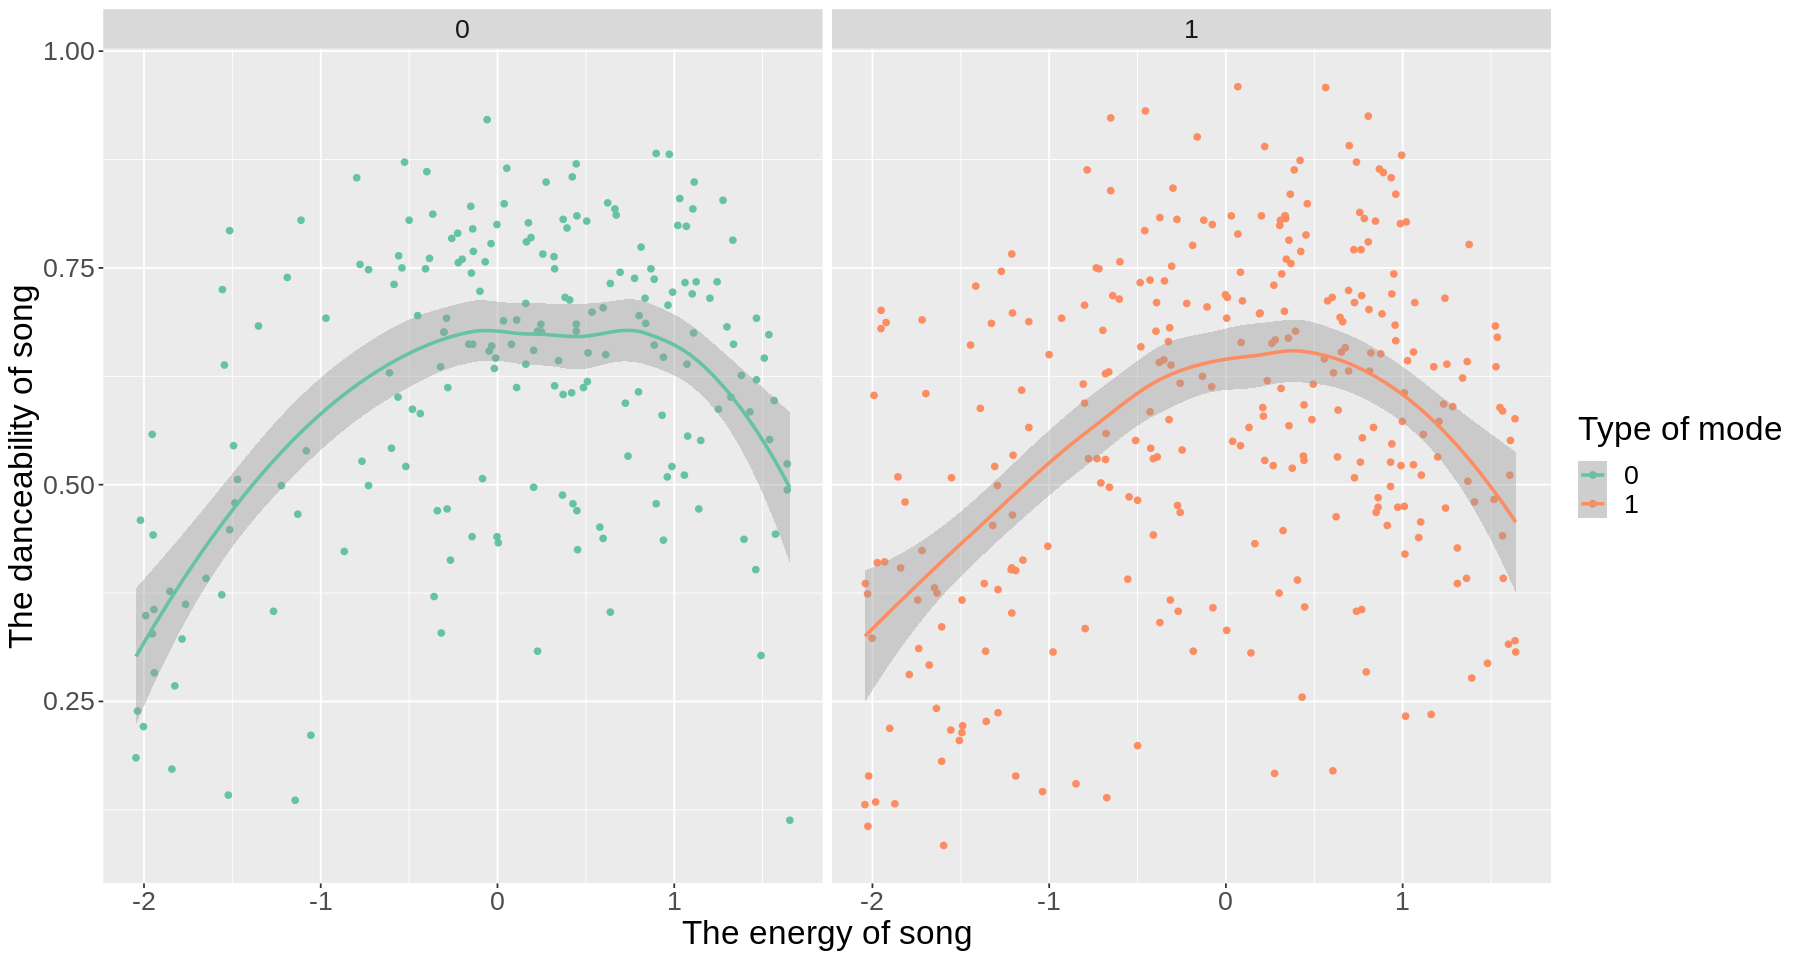

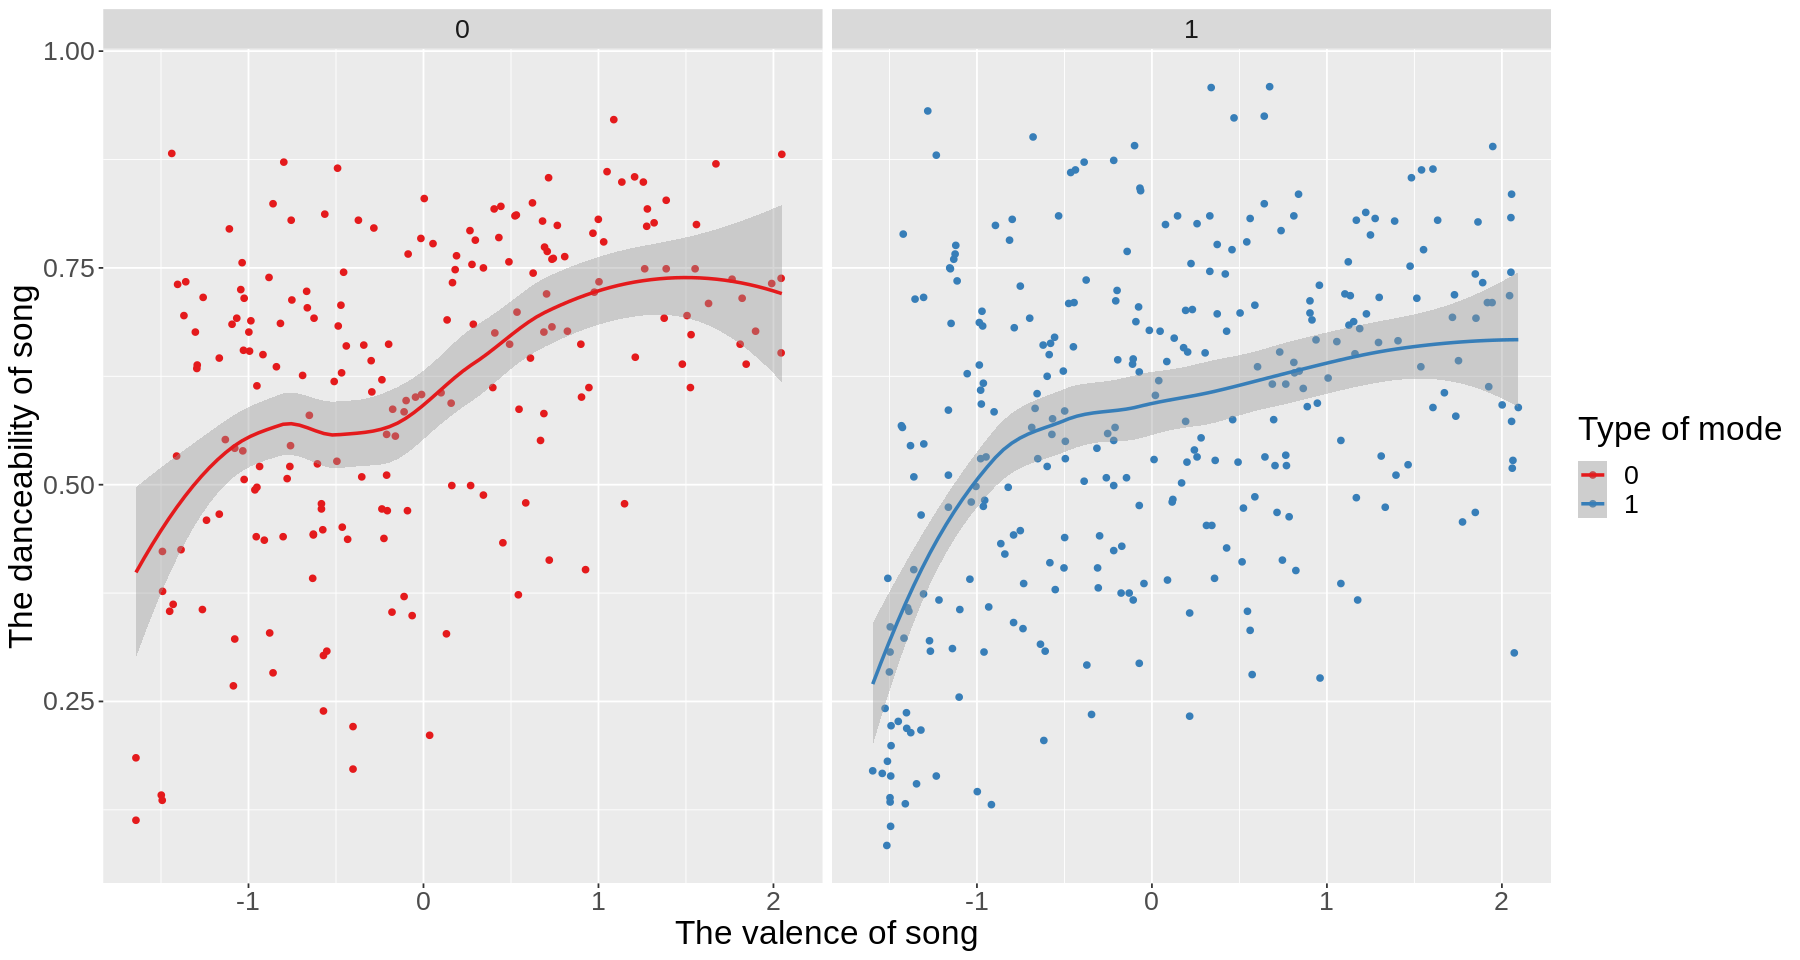

In [6]:
# Visualize the relationship between danceability and energy, classified by time_signature
options(repr.plot.width = 15, repr.plot.height = 8)

ggplot(spotify_training, aes(x = energy, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The energy of song", y = "The danceability of song", color = "Type of mode") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set2")

ggplot(spotify_training, aes(x = valence, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The valence of song", y = "The danceability of song", color = "Type of mode") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set1")